Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [1]:
import os
import sys
import shutil
import pathlib
from glob import glob

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Rescaling, experimental
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
import zipfile
warnings.filterwarnings("ignore")

2024-09-18 17:58:14.022702: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-18 17:58:14.022874: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-18 17:58:14.073782: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-18 17:58:14.202715: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-18 17:58:16.173759: W tensorflow/compiler/tf2

### Importing Skin Cancer Data

In [2]:
#If you are using the data by mounting the Google Drive, use the following :
from google.colab import drive
drive.mount('/content/drive')

data_dir_train = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

#Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

In [3]:
# try:
#     shutil.rmtree("Skin cancer ISIC The International Skin Imaging Collaboration")
# except:
#     print("No such file or directory, Extracting data from zip file")
# finally:
#     with zipfile.ZipFile("CNN_assignment.zip", 'r') as zip_ref:
#         zip_ref.extractall()



In [4]:
# # Defining the path for train and test images
# data_dir_train = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Train/')
# data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test/')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Defining some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180
num_classes = 9

In [7]:
# Train data set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset="training")

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


2024-09-18 17:58:27.542850: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-18 17:58:27.726710: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-18 17:58:27.726838: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-18 17:58:27.729653: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-18 17:58:27.729751: I external/local_xla/xla/stream_executor

In [8]:
# Validation data set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset="validation")

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
visualize one instance of all the nine classes present in the dataset

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_classes(dataset, class_names, img_height, img_width):
    num_classes = len(class_names)
    # Create a dictionary to store one example for each class
    class_examples = {i: None for i in range(num_classes)}

    # Extract one example per class
    for batch in dataset:
        images, labels = batch
        for image, label in zip(images, labels):
            label = int(label.numpy())  # Ensure label is a plain integer
            if class_examples[label] is None:
                image_np = image.numpy()  # Convert image to NumPy
                if image_np.ndim == 4:  # Handle case of batch dimension
                    image_np = image_np[0]
                class_examples[label] = image_np
            # Stop if we have one example per class
            if all(v is not None for v in class_examples.values()):
                break
        if all(v is not None for v in class_examples.values()):
            break

    # Plot the collected examples
    num_cols = 3
    num_rows = (num_classes // num_cols) + (num_classes % num_cols > 0)

    plt.figure(figsize=(num_cols * 4, num_rows * 4))
    for i, (cls, image) in enumerate(class_examples.items()):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.title(f'Class {class_names[cls]}')
        # Rescale image if needed
        if image.max() <= 1.0:  # If the image is normalized
            image = (image * 255).astype('uint8')  # Rescale to 0-255
        # Remove batch dimension if present
        if image.shape[-1] == 1:  # If grayscale, remove last dimension
            image = image.squeeze(axis=-1)
        plt.imshow(image.astype('uint8'))
        plt.axis('off')

    plt.tight_layout()
    plt.show()


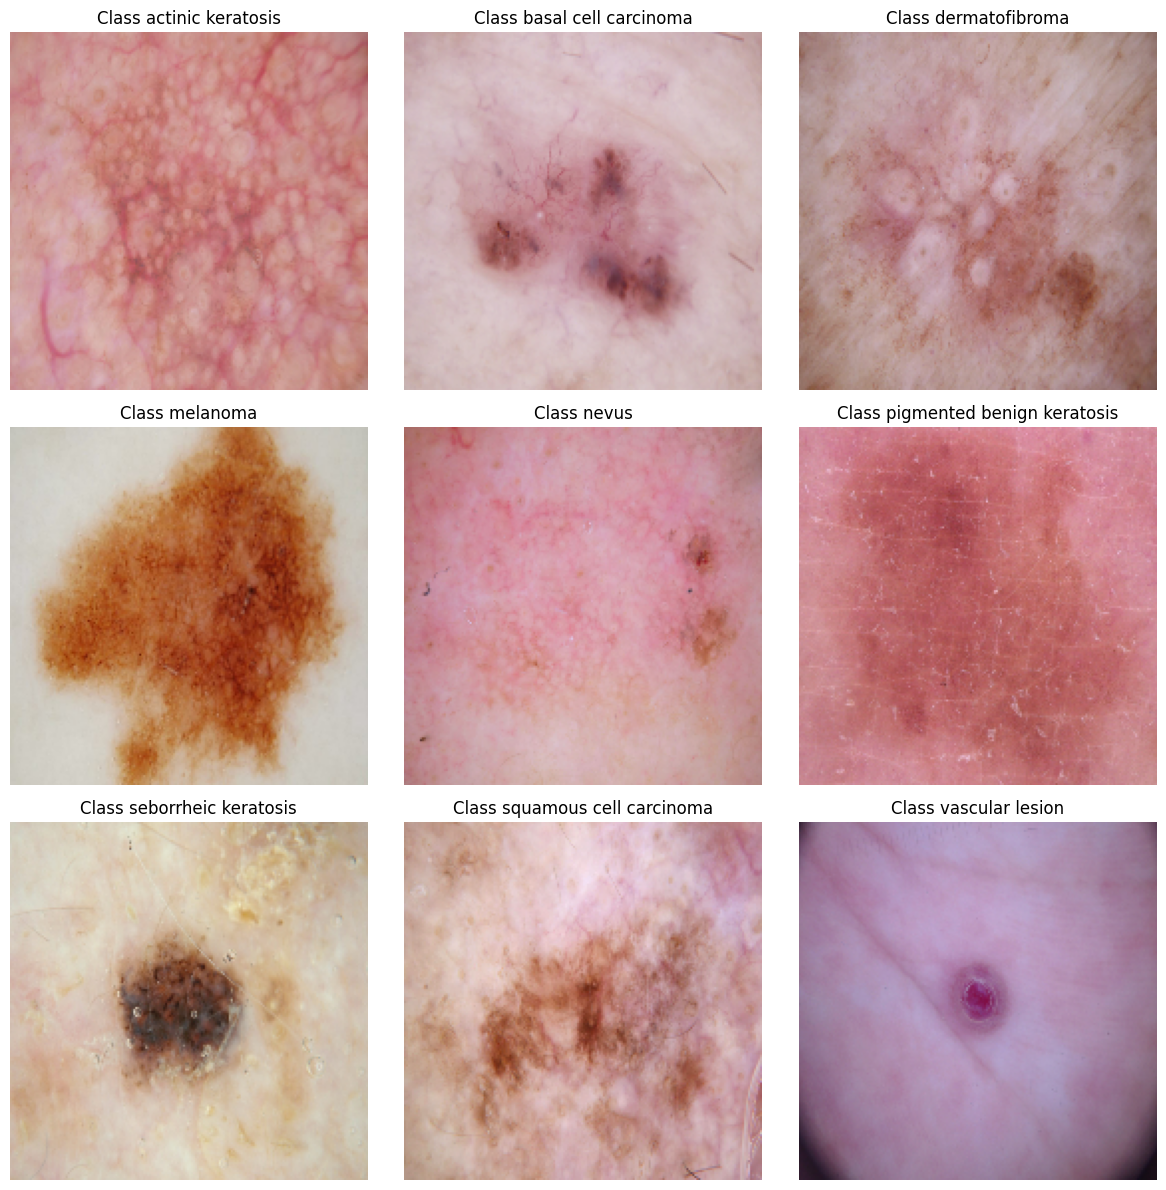

In [11]:
# Visualize classes
visualize_classes(train_ds, class_names, img_height, img_width)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

In [13]:
# Create CNN model
model_1 = Sequential([

    # Rescaling layer to normalize pixel values to [0, 1]
    Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    # First convolutional layer + max pooling
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Second convolutional layer + max pooling
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Third convolutional layer + max pooling
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Flattening layer to convert 3D feature maps into 1D feature vectors
    Flatten(),

    # Dense layer with 128 neurons
    Dense(128, activation='relu'),

    # Output layer with softmax activation for classification (9 classes)
    Dense(num_classes, activation='softmax')
])


### Compile the model

In [14]:
# Compile the model
model_1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [15]:
# Model summary to inspect the layers
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

### Train the model

In [16]:
epochs = 20
history = model_1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1
)

Epoch 1/20


2024-09-18 17:58:44.470605: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-09-18 17:58:44.857352: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-09-18 17:58:46.579151: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fcc10380560 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-18 17:58:46.579356: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-09-18 17:58:46.621076: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1726682326.885323   18249 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


56/56 [==============================] - 18s 105ms/step - loss: 2.0989 - accuracy: 0.2427 - val_loss: 1.9162 - val_accuracy: 0.2975
Epoch 2/20
56/56 [==============================] - 4s 65ms/step - loss: 1.7420 - accuracy: 0.3845 - val_loss: 1.5797 - val_accuracy: 0.4228
Epoch 3/20
56/56 [==============================] - 4s 65ms/step - loss: 1.5148 - accuracy: 0.4671 - val_loss: 1.4980 - val_accuracy: 0.4966
Epoch 4/20
56/56 [==============================] - 3s 62ms/step - loss: 1.4347 - accuracy: 0.4905 - val_loss: 1.4479 - val_accuracy: 0.5078
Epoch 5/20
56/56 [==============================] - 4s 63ms/step - loss: 1.3556 - accuracy: 0.5234 - val_loss: 1.5409 - val_accuracy: 0.4676
Epoch 6/20
56/56 [==============================] - 4s 64ms/step - loss: 1.2615 - accuracy: 0.5413 - val_loss: 1.4126 - val_accuracy: 0.5123
Epoch 7/20
56/56 [==============================] - 4s 65ms/step - loss: 1.1579 - accuracy: 0.5843 - val_loss: 1.3891 - val_accuracy: 0.5190
Epoch 8/20
56/56 [====

### Visualizing training results

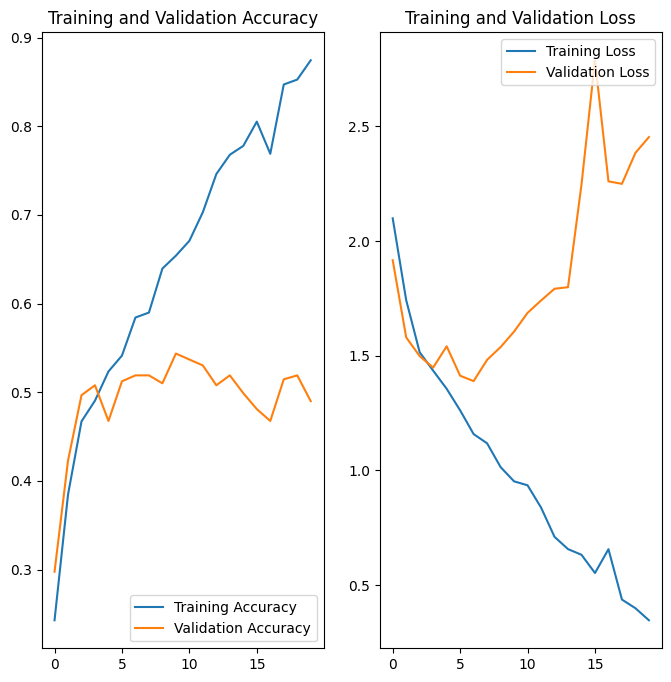

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Outcomes/Findings:
- We can see that the model is clearly overfitting because of class imbalance
- In the above graph we can see the accuracy of train and validation data, their is a huge gap between then which clearly show that model is overfiting
- The model is not peroforming well on the vadlidation set of data

### CNN Model with data Augmentation  

In [18]:
#Data augmentation strategy. 
data_augmentation_pipeline = tf.keras.Sequential([
  #Randomly flip each image horizontally and vertically.
  experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    
  #Randomly rotate each image.
  experimental.preprocessing.RandomRotation(0.2),
    
  #Randomly zoom each image during training.
  experimental.preprocessing.RandomZoom(0.2),
    
  #Randomly translate each image during training.
  experimental.preprocessing.RandomTranslation(0.1, 0.1)    
])



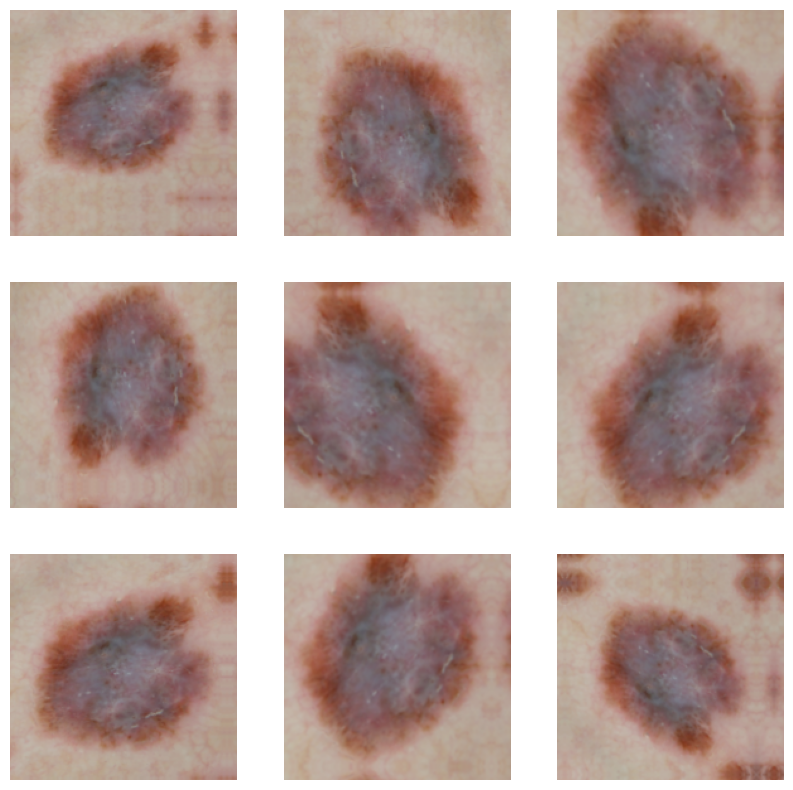

In [19]:
#Visualize the augmentation image
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):   
    for i in range(9):
        augmented_images = data_augmentation_pipeline(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")   

In [20]:
# Train data set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset="training")

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [21]:
# Validation data set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset="validation")

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [22]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model, compile and train the model

In [23]:
# Create CNN model
model_2 = Sequential([

    # Rescaling layer to normalize pixel values to [0, 1]
    Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    # Data augmentation
    data_augmentation_pipeline,

    # First convolutional layer + max pooling
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    # Second convolutional layer + max pooling
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    # Third convolutional layer + max pooling
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    # Flattening layer to convert 3D feature maps into 1D feature vectors
    Flatten(),

    # Dense layer with 256 neurons
    Dense(256, activation='relu'),

    # Dense layer with 128 neurons
    Dense(128, activation='relu'),

    # Dropout layer
    Dropout(0.35),

    # Output layer with softmax activation for classification (9 classes)
    Dense(num_classes, activation='softmax')
])


### Compile the model

In [24]:
# Compile the model
model_2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [25]:
# Model summary to inspect the layers
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 89, 89, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 64)        18496     
                                                      

### Train the model

In [26]:
epochs = 20
history = model_2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1
)

Epoch 1/20


2024-09-18 18:00:11.673908: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


56/56 [==============================] - 17s 148ms/step - loss: 2.1485 - accuracy: 0.2121 - val_loss: 1.9506 - val_accuracy: 0.2506
Epoch 2/20
56/56 [==============================] - 7s 133ms/step - loss: 1.9187 - accuracy: 0.2829 - val_loss: 1.7919 - val_accuracy: 0.4027
Epoch 3/20
56/56 [==============================] - 7s 131ms/step - loss: 1.7065 - accuracy: 0.3705 - val_loss: 1.6760 - val_accuracy: 0.3893
Epoch 4/20
56/56 [==============================] - 7s 122ms/step - loss: 1.6729 - accuracy: 0.3956 - val_loss: 1.6053 - val_accuracy: 0.4541
Epoch 5/20
56/56 [==============================] - 7s 125ms/step - loss: 1.5968 - accuracy: 0.4325 - val_loss: 1.5913 - val_accuracy: 0.4362
Epoch 6/20
56/56 [==============================] - 7s 127ms/step - loss: 1.5867 - accuracy: 0.4420 - val_loss: 1.5502 - val_accuracy: 0.4452
Epoch 7/20
56/56 [==============================] - 7s 133ms/step - loss: 1.5042 - accuracy: 0.4637 - val_loss: 1.5236 - val_accuracy: 0.4810
Epoch 8/20
56/56

### Visualizing training results

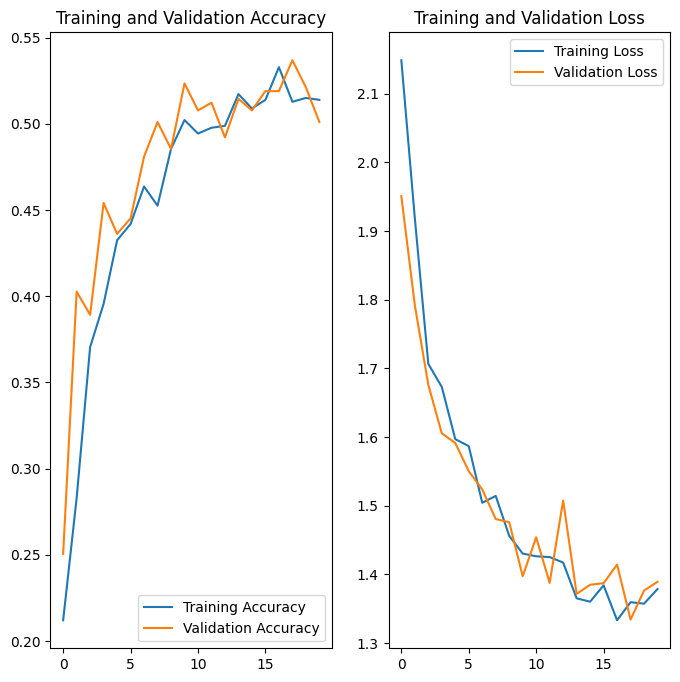

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Class Imbalance Detection

In [28]:
def class_distribution(dire):
    #count number of image in each classes
    count= []
    for path in pathlib.Path(dire).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(dire)
                    if os.path.isdir(os.path.join(dire, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

Image_Class_DF = class_distribution(data_dir_train)
print(Image_Class_DF)

                        Class  No. of Image
0     squamous cell carcinoma           181
1              dermatofibroma            95
2                       nevus           357
3             vascular lesion           139
4        basal cell carcinoma           376
5        seborrheic keratosis            77
6                    melanoma           438
7  pigmented benign keratosis           462
8           actinic keratosis           114


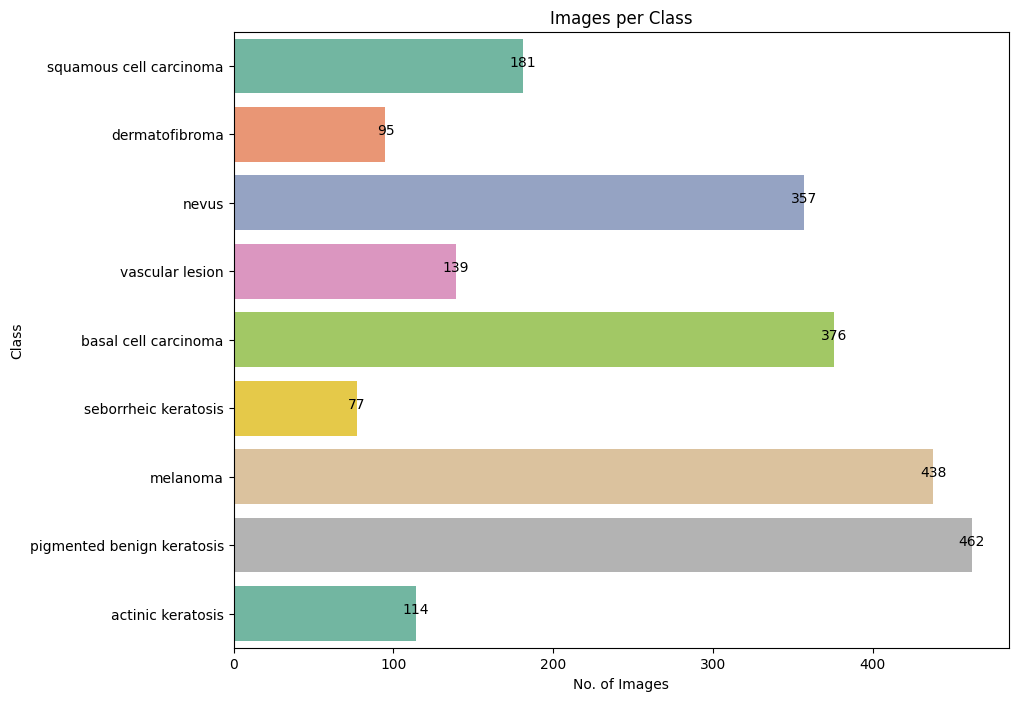

In [29]:
plt.figure(figsize=(10, 8))

# Create the barplot with unique colors for each bar
ax = sns.barplot(x="No. of Image", y="Class", data=Image_Class_DF, palette="Set2")

# Add annotations on each bar to show the exact count
for index, value in enumerate(Image_Class_DF['No. of Image']):
    ax.text(value + 0.2, index, f'{value}', color='black', ha="center")

# Set plot title and labels
plt.title("Images per Class")
plt.xlabel("No. of Images")
plt.ylabel("Class")

plt.show()

#### Findings:

- seborrheic keratosis has the least number of samples only 77.
- pigmented benign keratosis (462 Samples), melanoma (438 Samples), basal cell carcinoma (376 Samples), and nevus (357 Samples) classes dominate the data in terms of proportionate number of samples.

#### Rectify the class imbalance

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [30]:
path_to_training_dataset="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.random_contrast(probability=0.5, min_factor=0.7, max_factor=1.3)
    p.greyscale(probability=0.2)
    p.gaussian_distortion(probability=0.3, grid_width=4, grid_height=4, magnitude=2, corner="bell", method="in")
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FCC191E5F60>: 100%|███████████████████████| 500/500 [00:11<00:00, 41.68 Samples/s]


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FCC1922B1F0>: 100%|███████████████████████| 500/500 [00:13<00:00, 37.49 Samples/s]


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=L size=600x450 at 0x7FCC191AAC20>: 100%|█████████████████████████| 500/500 [00:13<00:00, 37.14 Samples/s]


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=L size=1024x768 at 0x7FCC194A54B0>: 100%|████████████████████████| 500/500 [00:33<00:00, 15.08 Samples/s]


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FCC18758C70>: 100%|██████████████████████| 500/500 [00:40<00:00, 12.28 Samples/s]


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FCC1974ECB0>: 100%|███████████████████████| 500/500 [00:13<00:00, 36.93 Samples/s]


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FCC193E3460>: 100%|██████████████████████| 500/500 [00:18<00:00, 27.12 Samples/s]


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FCC195484F0>: 100%|███████████████████████| 500/500 [00:13<00:00, 36.64 Samples/s]


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FCC1974FE20>: 100%|███████████████████████| 500/500 [00:14<00:00, 33.35 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [31]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [32]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#path_list

In [33]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
# lesion_list_new

In [34]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [35]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [36]:
df2['Label'].value_counts()

Label
squamous cell carcinoma       500
dermatofibroma                500
nevus                         500
vascular lesion               500
basal cell carcinoma          500
seborrheic keratosis          500
melanoma                      500
pigmented benign keratosis    500
actinic keratosis             500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [37]:
batch_size = 32
img_height = 180
img_width = 180

In [38]:
data_dir_train="Skin cancer ISIC The International Skin Imaging Collaboration/Train"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [39]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [40]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [41]:
model_3 = Sequential([

    # Rescaling layer to normalize pixel values to [0, 1]
    Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    # First convolutional layer + max pooling
    Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    # Second convolutional layer + max pooling
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    # Third convolutional layer + max pooling
    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    # Flattening layer to convert 3D feature maps into 1D feature vectors
    Flatten(),

    # Dense layer with 256 neurons
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),

    # Dense layer with 128 neurons
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),

    # Dropout layer
    Dropout(0.5),

    # Dense layer with 64 neurons
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),

    # Output layer with softmax activation for classification (9 classes)
    Dense(num_classes, activation='softmax')
])

In [42]:
# Compile the model
model_3.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [43]:
# Model summary to inspect the layers
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 conv2d_7 (Conv2D)           (None, 176, 176, 64)      18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 88, 88, 64)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 88, 88, 64)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 86, 86, 128)       73856     
                                                      

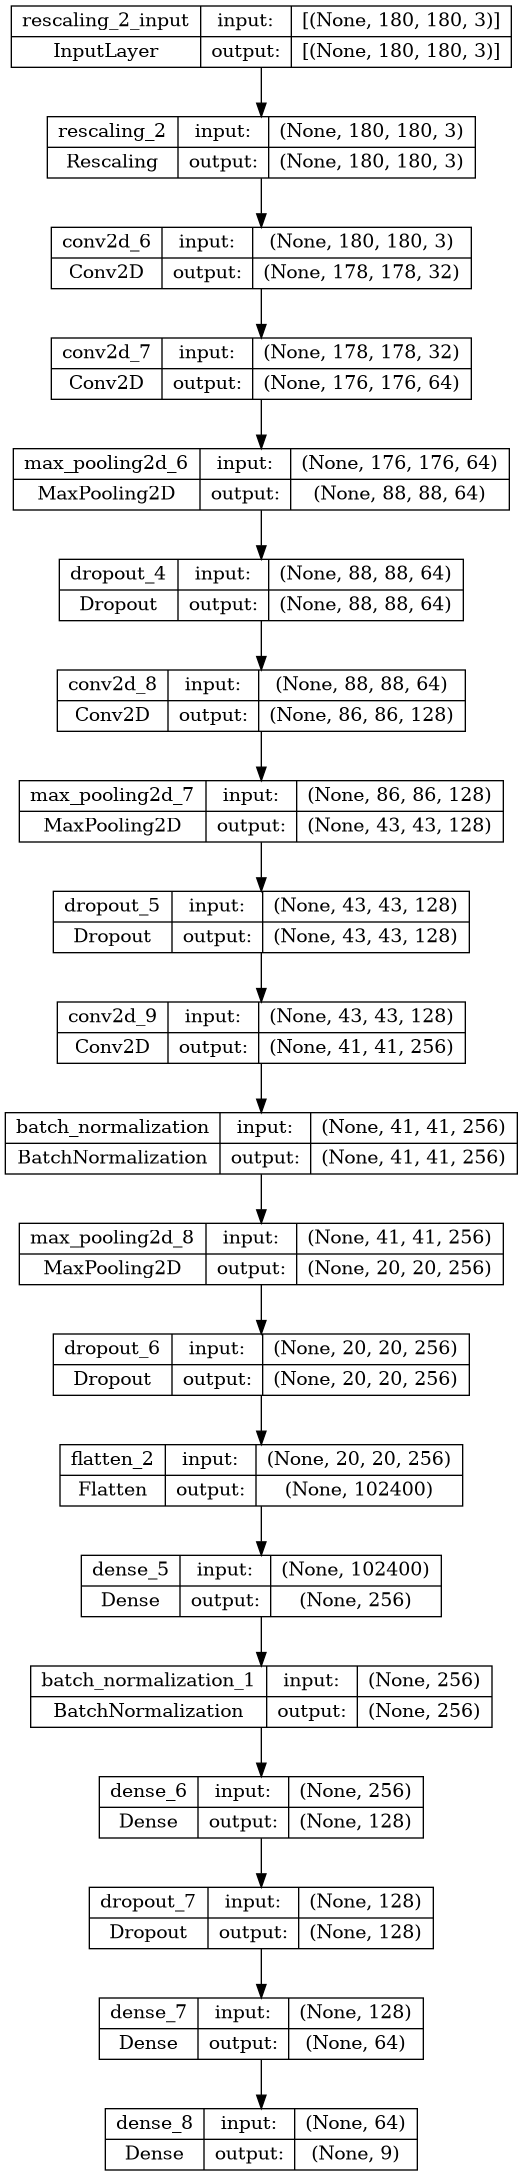

In [44]:
# vizualizing the model 
from tensorflow.keras.utils import plot_model
plot_model(model_3, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [34]:
# Callbacks for better training performance
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train the model
epochs = 50
history = model_3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/50


2024-09-18 17:08:33.685124: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


169/169 [==============================] - 65s 359ms/step - loss: 3.5145 - accuracy: 0.2083 - val_loss: 3.4111 - val_accuracy: 0.1863 - lr: 0.0010
Epoch 2/50
169/169 [==============================] - 55s 326ms/step - loss: 2.9419 - accuracy: 0.2574 - val_loss: 5.7311 - val_accuracy: 0.1114 - lr: 0.0010
Epoch 3/50
169/169 [==============================] - 56s 332ms/step - loss: 2.4593 - accuracy: 0.3303 - val_loss: 2.9245 - val_accuracy: 0.2212 - lr: 0.0010
Epoch 4/50
169/169 [==============================] - 57s 338ms/step - loss: 2.2756 - accuracy: 0.3733 - val_loss: 2.8618 - val_accuracy: 0.2606 - lr: 0.0010
Epoch 5/50
169/169 [==============================] - 57s 335ms/step - loss: 2.1310 - accuracy: 0.3846 - val_loss: 2.3977 - val_accuracy: 0.2962 - lr: 0.0010
Epoch 6/50
169/169 [==============================] - 55s 326ms/step - loss: 2.0802 - accuracy: 0.4015 - val_loss: 2.5338 - val_accuracy: 0.2843 - lr: 0.0010
Epoch 7/50
169/169 [==============================] - 55s 325ms

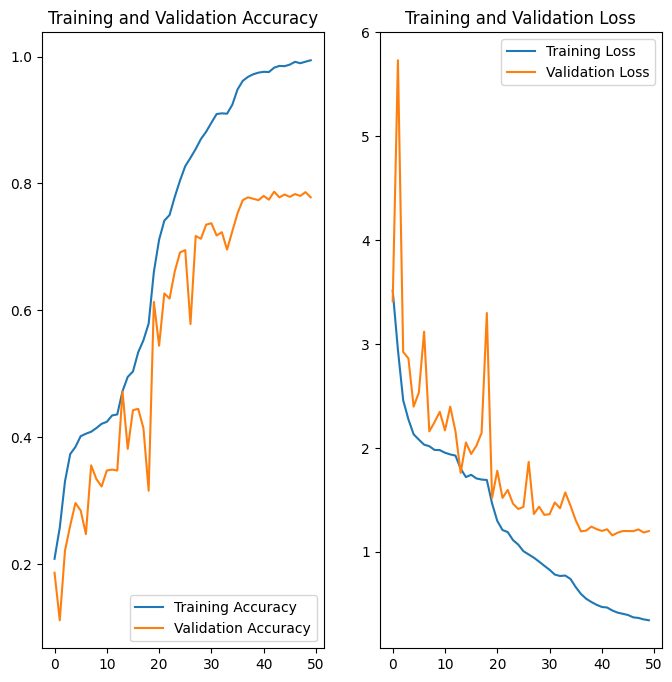

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### **Findings/Outcomes***

1. The training accuracy and validation accuracy are not same. But This is a sign of normal fit.
2. The training loss and validation loss are low.
3. The Validation accuracy is 0.78 which is good.


### Model predition on Test Data

Found 118 files belonging to 9 classes.
Class Names:  ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
4/4 [==============================] - 6s 1s/step
Accuracy: 0.40
Classification Report:
                            precision    recall  f1-score   support

         actinic keratosis       0.50      0.06      0.11        16
      basal cell carcinoma       0.62      0.50      0.55        16
            dermatofibroma       0.67      0.25      0.36        16
                  melanoma       0.23      0.19      0.21        16
                     nevus       0.33      0.81      0.47        16
pigmented benign keratosis       0.37      0.69      0.48        16
      seborrheic keratosis       0.00      0.00      0.00         3
   squamous cell carcinoma       0.50      0.25      0.33        16
           vascular lesion       0.60      1.00      0.75   

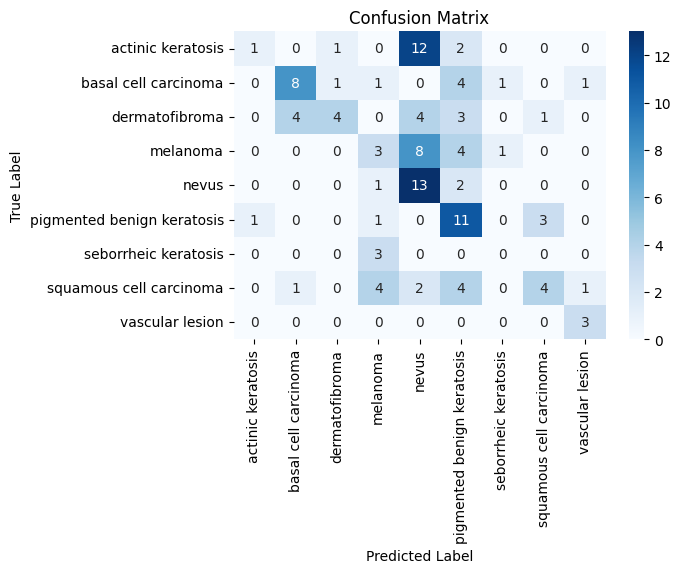

In [36]:
# Load test dataset without shuffling (so we can compare predictions to actual labels)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    seed=123,
    image_size=(180, 180),
    batch_size=batch_size,
    shuffle=False  # Important to keep the order of files for evaluation
)

# Class names from the dataset
class_names = test_ds.class_names
print("Class Names: ", class_names)

# Get the true labels and image file paths
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Predict on the test dataset
y_pred_probs = model_3.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(pd.DataFrame(conf_matrix, index=class_names, columns=class_names), annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()